In [1]:
%cd ..
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import sys
import seaborn as sns

import functions,loading

import nelpy as nel 

d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [11]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

basepath = 'Z:\Data\Kenji\ec013.451_470'
beh_df = loading.load_animal_behavior(basepath)
cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)
restrict_idx = ((cell_metrics.putativeCellType == "Pyramidal Cell") &
                    ((cell_metrics.brainRegion=="CA1") |
                    (cell_metrics.brainRegion=="rCA1") |
                    (cell_metrics.brainRegion=="lCA1")) &
                     (cell_metrics.bad_unit==False))

# restrict cell metrics                      
cell_metrics = cell_metrics[restrict_idx]

# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object)[restrict_idx], fs=fs_dat)


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [5]:
beh_df.epochs.unique()

array(['ec013.451_sleep', 'ec013.452_sleep', 'ec013.453_sleep',
       'ec013.454_linear', 'ec013.456_sleep', 'ec013.457_sleep',
       'ec013.458_sleep', 'ec013.459_bigSquare', 'ec013.460_bigSquare',
       'ec013.462_bigSquare', 'ec013.463_bigSquare', 'ec013.464_linear',
       'ec013.465_linear', 'ec013.466_linear', 'ec013.469_linear',
       'ec013.470_wheel'], dtype=object)

In [17]:
beh_df

,time,x,y,z,linerized,speed,acceleration,epochs
0,0.0000,NaN,NaN,NaN,NaN,NaN,0.0,ec013.451_sleep
1,0.0256,NaN,NaN,NaN,NaN,NaN,NaN,ec013.451_sleep
2,0.0512,NaN,NaN,NaN,NaN,NaN,NaN,ec013.451_sleep
3,0.0768,NaN,NaN,NaN,NaN,NaN,NaN,ec013.451_sleep
4,0.1024,NaN,NaN,NaN,NaN,NaN,NaN,ec013.451_sleep
...,...,...,...,...,...,...,...,...
705429,18058.9824,NaN,NaN,NaN,NaN,NaN,NaN,ec013.470_wheel
705430,18059.0080,NaN,NaN,NaN,NaN,NaN,NaN,ec013.470_wheel
705431,18059.0336,NaN,NaN,NaN,NaN,NaN,NaN,ec013.470_wheel
705432,18059.0592,NaN,NaN,NaN,NaN,NaN,NaN,ec013.470_wheel


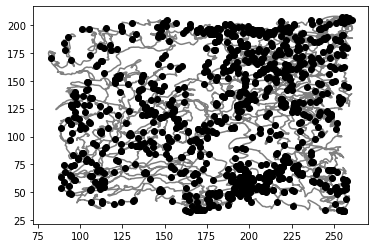

C:\Users\Cornell\AppData\Local\Temp/ipykernel_12244/2730975418.py:16: RuntimeWarning: invalid value encountered in true_divide


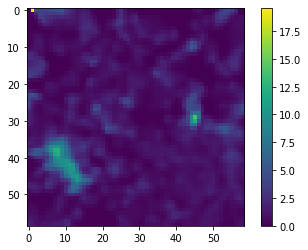

In [48]:
import statistics
from scipy.ndimage import gaussian_filter

def get_ratemap(ts,x,y,st,bin_width=3):
    fs = 1/statistics.mode(np.diff(ts))
    x_edges = np.arange(np.nanmin(x),np.nanmax(x),3)
    y_edges = np.arange(np.nanmin(y),np.nanmax(y),3)

    occ,_,_ = np.histogram2d(x,y,bins=(x_edges,y_edges))
    occ = occ/fs
    occ = gaussian_filter(occ, sigma=1)

    spk_mat,_,_ = np.histogram2d(np.interp(st,ts,x),np.interp(st,ts,y),bins=(x_edges,y_edges))
    spk_mat = gaussian_filter(spk_mat, sigma=1)

    ratemap = spk_mat / occ
    ratemap[np.isnan(ratemap)] = 0
    ratemap[np.isinf(ratemap)] = 0

    return ratemap

ts = beh_df[beh_df.epochs == 'ec013.459_bigSquare'].time
x = beh_df[beh_df.epochs == 'ec013.459_bigSquare'].x
y = beh_df[beh_df.epochs == 'ec013.459_bigSquare'].y

cell_id = 7
plt.plot(x,y,color='grey',zorder=-1000)
plt.scatter(np.interp(st_unit.data[cell_id],ts,x),np.interp(st_unit.data[cell_id],ts,y),color='k')
plt.show()
ratemap = get_ratemap(ts,x,y,st_unit.data[cell_id])
plt.imshow(ratemap)
plt.colorbar()

In [23]:
np.interp(st_unit.data[0],ts,x).shape

(24310,)

In [22]:
st_unit.data[0].shape

(24310,)